In [2]:
import numpy as np
import time
from utils import obs_to_lin_model, Environment
from typing import List
from model import LinearizedYankOmegaModel
from control.dlqr.decentralized_yolqr_crazyflie import DecentralizedYOLQRCrazyflie, YOState
from FedCE import FederatedLearning
import matplotlib.pyplot as plt
from utils.graph_fedce import plot_prediction_errors
plt.rcParams.update({
    "text.usetex": True
})

pybullet build time: Nov 28 2023 23:45:17


In [3]:
#load the data from files
path_prefix = "/home/erl/multi-robot/ros2_ws/"
data_path = path_prefix + "3square_transition_data.npy"
model_path = path_prefix + "3square_theta.npy"

data = np.load(data_path, allow_pickle=True)
model = np.load(model_path, allow_pickle=True)


In [4]:
# parse data into separate numpy arrays, need to split 38 dimensional data into state, u, phis, etp1
state, u, phis, etp1s = np.split(data, [10, 14, 28, ], axis=1)
print(f"{state.shape=} {u.shape=} {phis.shape=} {etp1s.shape=}")

state.shape=(4010, 10) u.shape=(4010, 4) phis.shape=(4010, 14) etp1s.shape=(4010, 10)


In [14]:
pred_errors = []
#loop over the data and predict the next state as we learn the model
G = 9.81
M =.035
MAX_THRUST = 0.3783857
CTRL_TIMESTEP = 0.01
env = Environment(G, M, MAX_THRUST, CTRL_TIMESTEP)
lin_model = LinearizedYankOmegaModel(env)
#for now Q,R arent used so just set = I
num_robots = 1
P = np.repeat(80*np.eye(14)[:, :, None], num_robots, axis=2).transpose(2, 0, 1)
# for i in range(num_robots):
#     P[i][-3:, -3:] = 5_000_000 * np.eye(3)
print("P=")
print(np.array_str(P, precision=3, suppress_small=True, max_line_width=100000))
dlqr = DecentralizedYOLQRCrazyflie(env, [lin_model], np.eye(10), np.eye(4), P = P)

def print_theta():
    thetaA = dlqr.theta[:dlqr.m * dlqr.num_robots, :].T
    thetaB = dlqr.theta[dlqr.m * dlqr.num_robots:, :].T
    theta_str = "Theta A:\n"
    theta_str += np.array_str(thetaA, precision=3, suppress_small=True, max_line_width=100000)
    theta_str += "\nTheta B:\n"
    theta_str += np.array_str(thetaB, precision=3, suppress_small=True, max_line_width=100000)

    print(theta_str)

# print_theta()
# fed = FederatedLearning(env, [lin_model], np.eye(10), np.eye(4))
for i in range(len(state)):
    
    x_tp1 = state[i]
    phi = phis[i]
    e_tp1 = etp1s[i]
    x_dot = dlqr.est_x_dot(x_tp1, phi)
    th_i = dlqr.get_thetai(0)
    pred_errors.append(np.linalg.norm(x_dot.T - phi.T @ th_i))
    dlqr.approx_theta_update(phi.reshape((1,-1)), e_tp1.reshape((1,-1)), project = True)

    #do model update based on data

print_theta()


P=
[[[80.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
  [ 0. 80.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
  [ 0.  0. 80.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
  [ 0.  0.  0. 80.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
  [ 0.  0.  0.  0. 80.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
  [ 0.  0.  0.  0.  0. 80.  0.  0.  0.  0.  0.  0.  0.  0.]
  [ 0.  0.  0.  0.  0.  0. 80.  0.  0.  0.  0.  0.  0.  0.]
  [ 0.  0.  0.  0.  0.  0.  0. 80.  0.  0.  0.  0.  0.  0.]
  [ 0.  0.  0.  0.  0.  0.  0.  0. 80.  0.  0.  0.  0.  0.]
  [ 0.  0.  0.  0.  0.  0.  0.  0.  0. 80.  0.  0.  0.  0.]
  [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0. 80.  0.  0.  0.]
  [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0. 80.  0.  0.]
  [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0. 80.  0.]
  [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0. 80.]]]
(10,)
(10,)
(10,)
(10,)
(10,)
(10,)
(10,)
(10,)
(10,)
(10,)
(10,)
(10,)
(10,)
(10,)
(10,)
(10,)
(10,)
(10,)
(10,)
(10,)
(10,)
(10,)
(10,)
(10,)
(10,)
(10,)

Text(0, 0.5, 'Prediction Error')

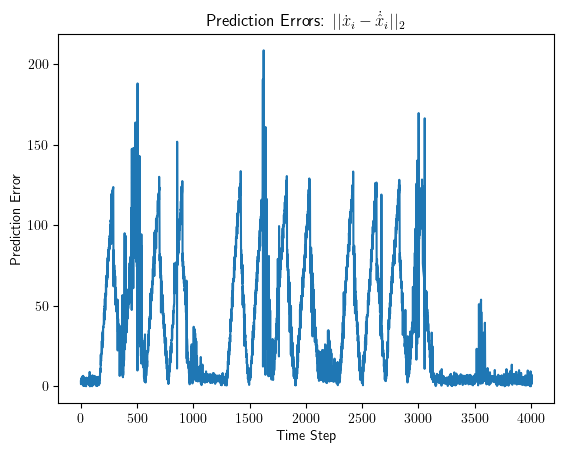

In [13]:

save_path = f"{path_prefix}3square_pred_errors.png"
plt.title("Prediction Errors: $|| \dot{x}_i - \dot{\hat{x}}_i||_2$")

plt.plot(pred_errors, label=f'$\hat{{\\theta}}_{i + 1}$ Pred')

plt.xlabel("Time Step")
plt.ylabel("Prediction Error")